**IBRES Maxime - M2 SIGMA** | Série temporelle : **Bretagne 24-25** |  Date de rendue : 30 Janvier 2026 

---

# === Importation des librairies utiles au projet ===

In [255]:
# Chemins
import os
import sys
sys.path.append("..")

In [271]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [257]:
# Graphiques
import matplotlib.pyplot as plt

In [258]:
# Images
from osgeo import gdal

In [259]:
# Librairie personnelle
from libsigma import read_and_write as rw

# === Configuration ===

## --- Chemins ---

In [260]:
# Dossier de travail
dir_path = "/home/onyxia/work"

In [261]:
# Dossier des données
data_path = os.path.join(dir_path, "data/projet_eval")
shp_path = os.path.join(data_path, "PI_strates_bretagne_32630.shp")

In [262]:
# Dossiers des résultats
result_path = os.path.join(dir_path, "results/figure")
os.makedirs(result_path, exist_ok=True)

In [263]:
# Définition de la nomenclature
nomenclature = {
    1: "Sol Nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

## --- Données de travail ---

### ➥ Échantillons obtenues par photo interprétation

In [264]:
gdf = gpd.read_file(shp_path)
label_strates = 'strate'
print(f"Nombre total d'échantillons chargés : {len(gdf)}")
display(gdf.head())

Nombre total d'échantillons chargés : 278


,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


### ➥ Série temporelle d’images Sentinel-2

#### Band 3 – Green

In [265]:
B03_path = os.path.join(data_path,"bretagne_24-25_B03.tif")
img_B03 = rw.open_image(B03_path)
B03_tab = rw.load_img_as_array(B03_path)

#### Band 5

In [266]:
B05_path = os.path.join(data_path,"bretagne_24-25_B05.tif")
img_B05 = rw.open_image(B05_path)
B05_tab = rw.load_img_as_array(B05_path)

# === Analyse des échantillons ===

In [267]:
# A. Nombre de polygones
# value_counts compte les occurrences, sort_index remet les classes 1, 2, 3, 4 dans l'ordre
serie_poly = gdf[label_strates].value_counts().sort_index()

# B. Nombre de pixels
# Sentinel-2 a une résolution de 10m (1 pixel = 100m²)
gdf['pixels_estimes'] = gdf.geometry.area / 100
serie_pix = gdf.groupby(label_strates)['pixels_estimes'].sum()

# C. Application des labels pour l'affichage
serie_poly.index = serie_poly.index.map(nomenclature)
serie_pix.index = serie_pix.index.map(nomenclature)

## --- Tableau récapitulatif bilan ---

In [268]:
df_recap = pd.DataFrame({
    'Nb Polygones': serie_poly,
    'Nb Pixels (est.)': serie_pix
})

total_poly = df_recap['Nb Polygones'].sum()
total_pix = df_recap['Nb Pixels (est.)'].sum()

df_recap['% Polygones'] = (df_recap['Nb Polygones'] / total_poly) * 100
df_recap['% Pixels'] = (df_recap['Nb Pixels (est.)'] / total_pix) * 100

row_total = pd.DataFrame({
    'Nb Polygones': [total_poly], 
    'Nb Pixels (est.)': [total_pix],
    '% Polygones': [100.0],
    '% Pixels': [100.0]
}, index=['TOTAL'])

df_recap_final = pd.concat([df_recap, row_total])

display(df_recap_final.style.format({
    'Nb Polygones': '{:.0f}',
    'Nb Pixels (est.)': '{:,.0f}',
    '% Polygones': '{:.2f} %',
    '% Pixels': '{:.2f} %'
}))

,Nb Polygones,Nb Pixels (est.),% Polygones,% Pixels
Herbe,86,"1,075",30.94 %,27.58 %
Landes,121,"1,602",43.53 %,41.08 %
Arbre,71,"1,222",25.54 %,31.34 %
TOTAL,278,"3,899",100.00 %,100.00 %


## --- Graphiques ---

In [269]:
# A. Graphique Polygones
plt.figure(figsize=(8, 6))
ax_p = serie_poly.plot(kind='bar', color='lightblue')
ax_p.bar_label(ax_p.containers[0], padding=3)
plt.title("Répartition du nombre de polygones par classe")
plt.ylabel("Nombre de polygones")
plt.ylim(0, serie_poly.max() * 1.1)
plt.savefig(os.path.join(result_path, "diag_baton_nb_poly_by_class.png"), bbox_inches='tight')
plt.close()
print(f"=> Graphique 'diag_baton_nb_poly_by_class.png' sauvegardé dans {result_path}.")

# B. Graphique Pixels
plt.figure(figsize=(8, 6))
ax_px = serie_pix.plot(kind='bar', color='lightgreen')
ax_px.bar_label(ax_px.containers[0], fmt='{:,.0f}', padding=3)
plt.title("Répartition du nombre de pixels (estimé) par classe")
plt.ylabel("Nombre de pixels")
plt.ylim(0, serie_pix.max() * 1.1)
plt.savefig(os.path.join(result_path, "diag_baton_nb_pix_by_class.png"), bbox_inches='tight')
plt.close()
print(f"=> Graphique 'diag_baton_nb_pix_by_class.png' sauvegardé dans {result_path}.")

=> Graphique 'diag_baton_nb_poly_by_class.png' sauvegardé dans /home/onyxia/work/results/figure.
=> Graphique 'diag_baton_nb_pix_by_class.png' sauvegardé dans /home/onyxia/work/results/figure.


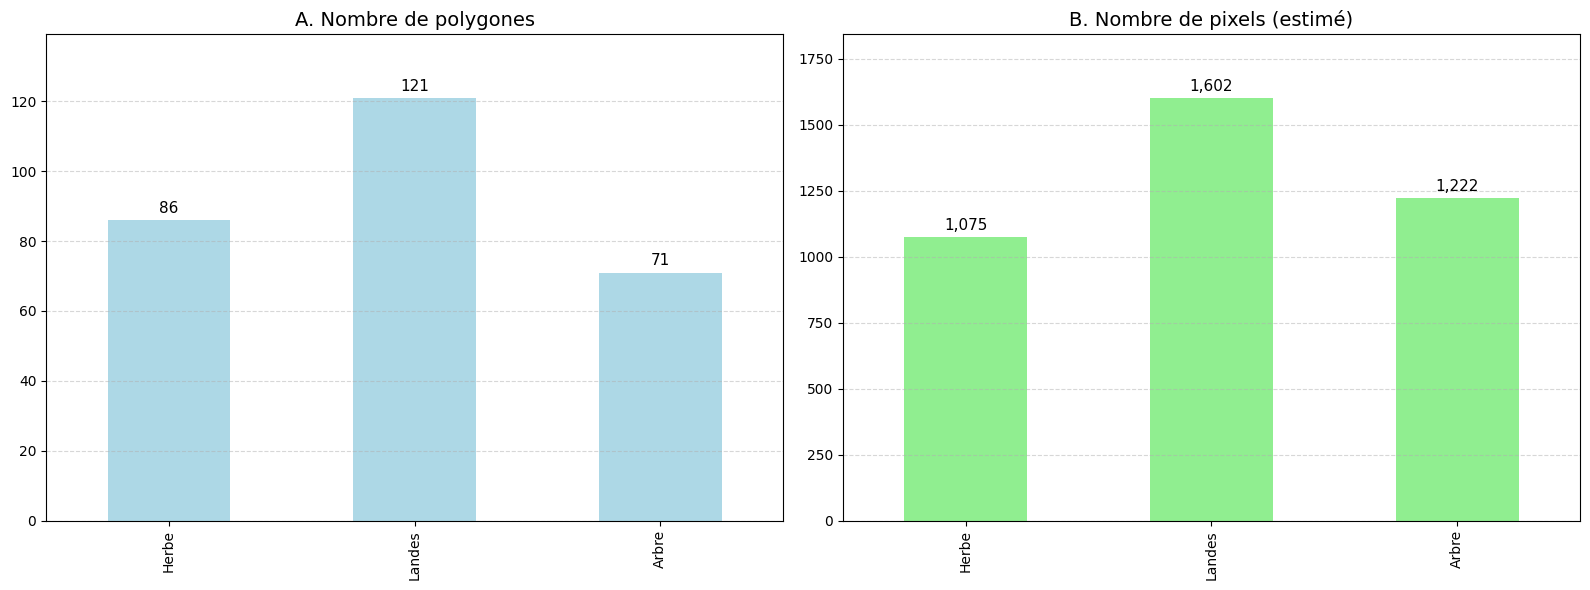

In [270]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphe de gauche (Polygones)
serie_poly.plot(kind='bar', ax=ax1, color='lightblue')
ax1.set_title("A. Nombre de polygones", fontsize=14)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_ylim(0, serie_poly.max() * 1.15)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.bar_label(ax1.containers[0], padding=3, fontsize=11)

# Graphe de droite (Pixels)
serie_pix.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title("B. Nombre de pixels (estimé)", fontsize=14)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_ylim(0, serie_pix.max() * 1.15)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.bar_label(ax2.containers[0], fmt='{:,.0f}', padding=3, fontsize=11)

plt.tight_layout()
plt.show()

On observe une prédominance de la classe "Landes", à la fois en nombre de polygones et en nombre de pixels. C'est intéressant car c'est la classe cible principale de l'étude (pour la mise en évidence des éricacées). Les classes "Herbe" et "Arbre" sont moins représentées mais restent dans un ordre de grandeur comparable. Aucun polygone de la classe "Sol Nu" n'est présent dans le fichier d'échantillons.

# === Phénologie des strates ===

In [ ]:
data_type_match = {'float32': gdal.GDT_Float32}

In [ ]:
# define parameters
out_nari_filename = os.path.join(result_path, 'ARI_serie_temp.tif')